# PAE second stage

PAE consists of 2 stages: 

1) an Auto-Encoder (AE) that was trained to reach optimal reconstructions     

2) a normalizing flow trained to Gaussianize the latent space of the AE    

Both need to be trained *separately* otherwise the model will not be optimal. 
The PAE outperforms VAEs because of that split. The AE should not be replaced by an VAE, otherwise you will pay penalty in model performance.


This notebook contains code to train the second stage (the normalizing flow).

*Nomenclature*: I will refer to the latent space variable of the AE as *z* or embedded space. And I will refer to the latent space of the normalizing flow as *u* or latent space.

The bijector of the normalizing flow in this notebook is made out of  transformation layers and permutation layers. The tranformations can either be a shift and rescale transformation (RealNVP) or a spline transformation (Neural Spline Flow). Every second permutation layer is trainable (GLOW).

The user can set the number of layers of each transformation.

In [89]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
 
plt.rcParams.update({'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

print(tf.__version__)

2.3.0


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
#
import tensorflow 
#import keras.backend.tensorflow_backend as KTF
gpu_devices = tensorflow.config.experimental.list_physical_devices('GPU')

for device in gpu_devices:
    tensorflow.config.experimental.set_memory_growth(device,True)
    
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tensorflow.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tensorflow.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

tfp.__version__

'0.11.0'

In [5]:
collaboratory = True

if collaboratory:
    from google.colab import drive
    drive.mount('/content/drive')
else: 
    print('Running on local systems, if running on collaboratory please change above')

ModuleNotFoundError: No module named 'google.colab'

### Step 1: Load the AE embedded data. This will be the input data for training the normalizing flow.

In [79]:
# loading embedding extracted from jupyter notebook
DATA_PATH = ''
emb = np.load(os.path.join(DATA_PATH,'pie_Train_Loss:0.0036-19999.npy'))

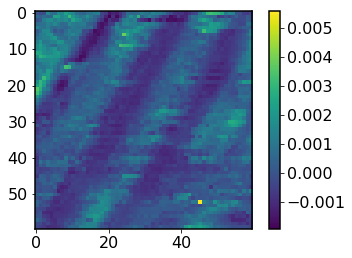

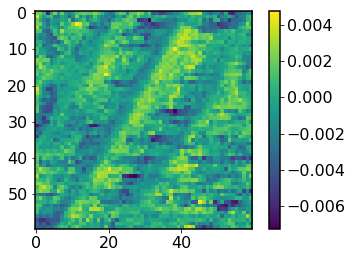

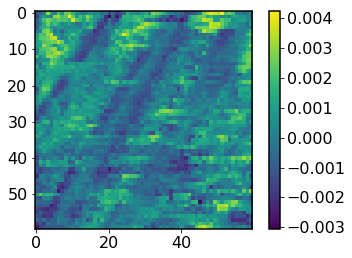

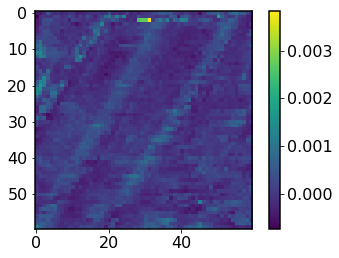

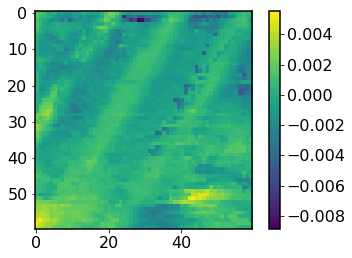

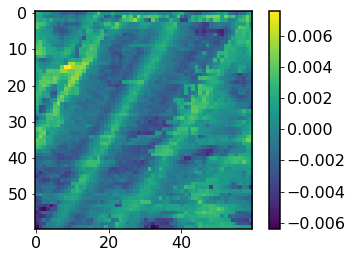

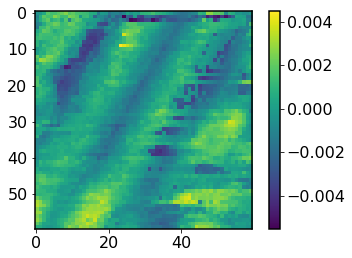

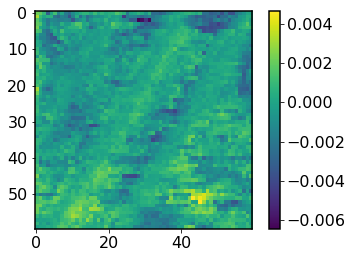

In [90]:
for i in range(8):
    plt.figure()
    plt.imshow(emb[:,i].reshape(60,60))
    plt.colorbar()

Step 2: find or set dimensions that the model should use

In [91]:
non_zero_dims = [0,1,2,3,4,5,6,7]

In [43]:
# # finding non-zero embeddings
# non_zero_dims = []
# for ii in range(16):
#     if len(np.where(emb[:,ii]!=0.)[0])>0:
#         print(len(np.where(emb[:,ii]!=0.)[0]))
#         non_zero_dims.append(ii)
        
# print(non_zero_dims)

In [44]:
emb.shape[-1]

8

In [92]:
# latent size is smaller than embedding size due to sparsity
params={}
params['latent_size']    = len(non_zero_dims)
params['embedding_size'] = emb.shape[-1]


where you want the model to be saved:

In [46]:
# path for saving the model
params['module_dir'] = 'vae_simple_model_1/'

Step 3: design the normalizing flow. Set the number of layers that you want for each type of transformation.

In [93]:
# number of transformations in the bijection
N_spline_layers = 2
N_rescale_shift_layers = 2
N_shift_layers = 2

In [94]:
nvp_depth = N_spline_layers+N_rescale_shift_layers+N_shift_layers

Dont worry about the next cells, where I'm building the normalizing flow.

In [95]:
dims         = np.asarray([len(non_zero_dims) for ii in range(nvp_depth)]) 
nvp_size     = np.arange(nvp_depth) 
indices      = np.arange(len(non_zero_dims))
nvp_depth    = N_spline_layers+N_rescale_shift_layers+N_shift_layers

In [96]:
# target distribution
def get_prior(latent_size):
    return tfd.MultivariateNormalDiag(tf.zeros(latent_size), scale_identity_multiplier=1.0)

In [97]:
# bijector for permutations (GLOW)

def trainable_lu_factorization(
    event_size, batch_shape=(), seed=None, dtype=tf.float32, name=None):
    with tf.name_scope(name or 'trainable_lu_factorization'):
        event_size = tf.convert_to_tensor(
            event_size, dtype_hint=tf.int32, name='event_size')
        batch_shape = tf.convert_to_tensor(
            batch_shape, dtype_hint=event_size.dtype, name='batch_shape')
        random_matrix = tf.random.uniform(
            shape=tf.concat([batch_shape, [event_size, event_size]], axis=0),
            dtype=dtype,
            seed=seed)
        random_orthonormal = tf.linalg.qr(random_matrix)[0]
        lower_upper, permutation = tf.linalg.lu(random_orthonormal)
        lower_upper = tf.Variable(
            initial_value=lower_upper,
            trainable=True,
            name='lower_upper')
        # Initialize a non-trainable variable for the permutation indices so
        # that its value isn't re-sampled from run-to-run.
        permutation = tf.Variable(
            initial_value=permutation,
            trainable=False,
            name='permutation')
        return lower_upper, permutation


In [98]:
# splines for Neural Spline Flow

class SplineParams(tf.Module):

    def __init__(self, nunits, nbins=32):
        self._nbins = nbins
        self._nunits= nunits
        self._built = False
        self._bin_widths = None
        self._bin_heights = None
        self._knot_slopes = None

    def _bin_positions(self, x):
        x = tf.reshape(x, [-1,self._nunits,self._nbins])
        # you can try to take out layers here
        net = tf.layers.Dense(self._nunits)(x)
        net = tf.nn.leaky_relu(net)
        net = tf.layers.Dense(self._nunits)(net)
        # net = tf.nn.leaky_relu(net)
        # net = tf.layers.Dense(self._nbins)(net)
        net = tf.reshape(net, [-1,self._nunits, self._nbins])
        return tf.math.softmax(net, axis=-1) * (2 - self._nbins * 1e-2) + 1e-2

    def _slopes(self, x):
        x = tf.reshape(x, [-1,  self._nunits, ( self._nbins - 1)])
        net = tf.layers.Dense(self._nunits)(x)
        net = tf.nn.leaky_relu(net)
        # net = tf.layers.Dense(self._nbins-1)(net)
        net = tf.reshape(net, [-1,  self._nunits, ( self._nbins - 1)])
        return tf.math.softplus(x) + 1e-2

    def __call__(self, x, nunits):

        bin_positions = self._bin_positions
        if not self._built:
            self._bin_widths  = tf.layers.Dense(self._nunits * self._nbins, activation=bin_positions, name='w')
            self._bin_heights = tf.layers.Dense(self._nunits * self._nbins, activation=bin_positions, name='h')
            self._knot_slopes = tf.layers.Dense(self._nunits * (self._nbins - 1), activation=self._slopes, name='s')
        self._built = True
        result = tfb.RationalQuadraticSpline(bin_widths=self._bin_widths(x),bin_heights=self._bin_heights(x),knot_slopes=self._knot_slopes(x))
        
        return result

In [99]:
def init_once(x, name):
    return tf.get_variable(name, initializer=x, trainable=False)

def get_nvp():
    chain             = []
    reduction         = (params['latent_size']-dims)/params['latent_size']
    current_size      = []
    perms_swap        = []
    perms_rand        = []
    perms_train       = []
    splines           = []
    size              = []
    #current_size      = params['latent_size']
    for i,s in enumerate(nvp_size):
        current_size  = np.int(params['latent_size']*(1-reduction[i]))
        swapping      = np.concatenate((np.arange(current_size//2,current_size),np.arange(0, current_size//2)))
        perms_swap.append(tfb.Permute(permutation=init_once(swapping,name="perm_swap%d"%i)))
        perms_train.append(tfb.MatvecLU(*trainable_lu_factorization(current_size),validate_args=True, name="perms_train%d"%i))
        splines.append(SplineParams(current_size//2))
        size.append(current_size)
        print(current_size, size)


# model can be composed of different element of GLOW, NSF, Real NVP, use the if statements for modifications
    for i,s in enumerate(nvp_size):
        if i%2==0:
            chain.append(tfb.Blockwise(bijectors=[perms_train[i],tfb.Identity()],block_sizes=[size[i],params['latent_size']-size[i]]))
        else:
            chain.append(tfb.Blockwise(bijectors=[perms_swap[i],tfb.Identity()],block_sizes=[size[i],params['latent_size']-size[i]]))
        if i<N_spline_layers: 
            # spline bijector
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,bijector_fn=splines[i])
        if i<N_spline_layers and i>N_shift_layers+N_spline_layers:
            # shift and scale 
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[params['latent_size'],params['latent_size']]))                 
        else:
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[params['latent_size'],params['latent_size']],shift_only=True))  
        bijector2 = tfb.Identity()
        chain.append(tfb.Blockwise(bijectors=[bijector1, bijector2], block_sizes=[size[i],params['latent_size']-size[i]]))
    # Neural spline flow needs to act on interval [-1,1], hence the scaling
    chain.append(tfb.Scale(5))
    
    # p(x) is Gaussian, chain: y=g(x)
    # bwd goes from last to first in the chain (inverse)
    nvp=tfd.TransformedDistribution(distribution=tfd.Normal(0,1),bijector=tfb.Chain(chain),name='mynvp', event_shape=(params['latent_size'],))
                 
    return nvp

def nvp_module_spec():
    z_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    sample_size  = tf.placeholder(tf.int32, shape=[])
    u_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    nvp_         = get_nvp()
    log_prob     = nvp_.log_prob(z_sample)
    nvp_sample   = nvp_.sample(sample_size)
    nvp_fwd_pass = nvp_.bijector.forward(u_sample)
    nvp_bwd_pass = nvp_.bijector.inverse(z_sample)
    hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample}\
                      ,outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass, 'bwd_pass': nvp_bwd_pass})

This is the graph of our model. It is just the model. Think of is as a class. It has not been filled with numbers yet. I will explain below how to use it.

In [100]:
# model in good old tf1 style

tf.reset_default_graph()

# learning rate
lr            = tf.placeholder_with_default(0.001,shape=[])
# input data
data          = tf.placeholder(shape=[None,params['embedding_size']],dtype=tf.float32)
# input data
latent_sample = tf.placeholder(shape=[None,len(non_zero_dims)],dtype=tf.float32)
# ba
bs            = tf.placeholder_with_default(16,shape=[])

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)
prior         = get_prior(params['latent_size'])

# ----------------------------------module to save the model----------------------------------------------------------#
nvp_spec  = hub.create_module_spec(nvp_module_spec)
# this is how you would load the module instead of creating a new one 
## nvp_funcs = hub.Module(params['module_dir'], trainable=True)
nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)
#---------------------------------------------------------------------------------------------------------------------#
# select non-zero dimensions of the data
comp_data      = tf.gather(data,non_zero_dims,axis=1)
#-------------------------------------------------training------------------------------------------------------------#
log_prob       = nvp_funcs({'z_sample':comp_data,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob']
# the training loss is transformed distribution
loss           = -tf.reduce_mean(log_prob)
# evaluates one training step
opt_op_nvp     = optimizer.minimize(loss)
#---------------------------------------------------------------------------------------------------------------------#


#project into Gaussian space
bwd            = nvp_funcs({'z_sample':comp_data,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['bwd_pass']
#draw from the Gaussian 
prior_sample   = prior.sample(bs)
# fwd model these draws back into the embedding space
fwd            = nvp_funcs({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':latent_sample},as_dict=True)['fwd_pass']

8 [8]
8 [8, 8]
8 [8, 8, 8]
8 [8, 8, 8, 8]
8 [8, 8, 8, 8, 8]
8 [8, 8, 8, 8, 8, 8]
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [101]:
# initialize the session to evaluate your graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Examples for how to use the model we have built.

Ex1 : evaluate the log probability of data under the model

In [103]:
# the feed dict is the disctioanry of values that you feed into the graph. here it is the embedded data.
log_prob_of_emb = sess.run(log_prob, feed_dict={data:emb})

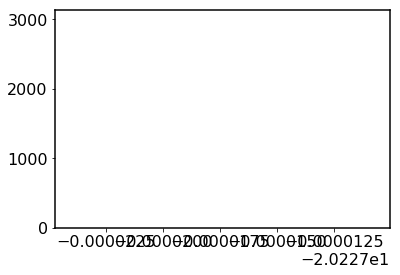

In [106]:
# note that this is before we have trained the model
_  = plt.hist(log_prob_of_emb, bins=100)

### Ex 2.: Transforming data from z-sapce to u-space (embedded data to Gaussianized data)

In [107]:
u_data = sess.run(bwd, feed_dict={data:emb})

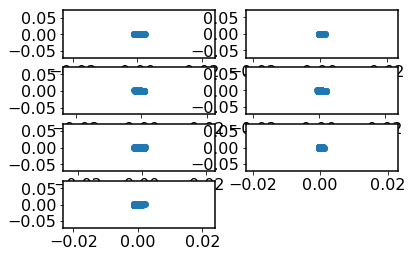

In [108]:
# input data in 'Gaussian' space
for ii in range(params['latent_size']-1):
    plt.subplot(4,2, ii+1)
    plt.scatter(u_data[:,ii],u_data[:,ii+1])

### Ex 3.:  Draw a random sample in the Gaussian space (u-space) and bring it into the embedded space (z_space)

In [110]:
# draw random sample from normal of size 1024
u_sample = sess.run(prior_sample, feed_dict={bs:1024})

In [111]:
# bring this sanmple into the embedded space of the auto-enocder
z_sample = sess.run(fwd,  feed_dict={latent_sample: u_sample})

In [112]:
z_sample.shape

(1024, 8)

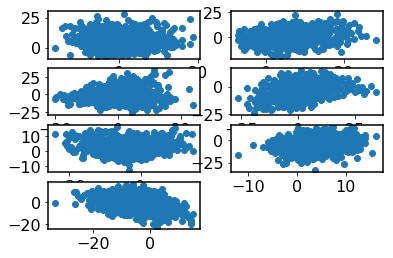

In [113]:
# random samples in z_space (note again, we havent trained the model yet, so the output will not match the embedded data)
for ii in range(params['latent_size']-1):
    plt.subplot(4,2, ii+1)
    plt.scatter(z_sample[:,ii],z_sample[:,ii+1])

For your purpose, if after training you wanted to interpolate between two embedded points and look at the result in the data space, you would:

1) encode the data points with the AE

2) encode the embedded data points with the NF by running code like in example 2

3) interpolate/ move the points in this space

4) forward model the new points with code like in example 3 (not the random sampling just the fwd step) 

5) forward model with the decoder of the autoencoder



### Ex 4: Evaluate the loss (negative log probability) and perform one training step

In [114]:
# loss for batch of 16 data points
loss_batch = sess.run(loss,  feed_dict={data: emb[0:16]})

In [115]:
loss_batch

20.227013

In [116]:
# one optimization step (need to pass training data and learning rate)
_  = sess.run(opt_op_nvp,  feed_dict={data: emb[0:16], lr:1e-3})

In [117]:
# loss after optimziation step
sess.run(loss,  feed_dict={data: emb[0:16]})

20.200993

## Training

In [118]:
nvp_tloss = []
nvp_vloss = []
ii     = 0

In [69]:
# splitting into training and validation data
train_size = int(len(emb)/6*5)
print('sample size of training sample', train_size)
z_sample   = emb[:train_size]
z_sample_valid = emb[train_size:,] 
valid_size = len(z_sample_valid)
print('sample size of validation sample', valid_size)
z_sample_train = z_sample[:]

sample size of training sample 3000
sample size of validation sample 600


In [135]:
# modify to use all the data for training

train_size = int(len(emb))
print('sample size of training sample', train_size)
z_sample   = emb
z_sample_valid = emb
valid_size = len(z_sample_valid)
print('sample size of validation sample', valid_size)
z_sample_train = z_sample[:]

sample size of training sample 3600
sample size of validation sample 3600


In [174]:
# set initial learning rate, batchsize and number of epochs
learning_rate = 8e-5
batchsize     = 16
n_epochs      = 1500


break_count =0
while ii<n_epochs:
    print('epoch ', ii)
    # number of iterations for one epoch given current batchsize
    epoch = train_size//batchsize
    jj    = 0 
    while jj<epoch:
        # take one optimization step and evaluate current loss
        _, ll = sess.run([opt_op_nvp,loss],  feed_dict={lr: learning_rate, data:z_sample_train[jj*batchsize:(jj+1)*batchsize]})
        jj+=1

    ll = sess.run(loss,  feed_dict={lr: learning_rate, data:z_sample_train[:len(z_sample_valid)]})
    nvp_tloss.append(ll)
    lv = sess.run(loss,  feed_dict={lr: learning_rate, data:z_sample_valid})
    print('train loss: ', ll, 'val loss: ', lv)
    nvp_vloss.append(lv)
    # reshuffle data before next training epoch
    np.random.shuffle(z_sample) 
#     if ii%20==0 and ii>0:
#       # saves the model at regular intervals
#         nvp_path = os.path.join(params['module_dir'],'run1_nepoch%d'%ii)
#         try:
#             nvp_funcs.export(nvp_path,sess)
#         except:
#             pass
    ii+=1

epoch  1000
train loss:  -45.733475 val loss:  -45.733475
epoch  1001
train loss:  -41.41707 val loss:  -41.41707
epoch  1002
train loss:  -41.748123 val loss:  -41.748123
epoch  1003
train loss:  -42.905376 val loss:  -42.905376
epoch  1004
train loss:  -43.6204 val loss:  -43.6204
epoch  1005
train loss:  -43.54355 val loss:  -43.54355
epoch  1006
train loss:  -44.29493 val loss:  -44.29493
epoch  1007
train loss:  -45.50276 val loss:  -45.50276
epoch  1008
train loss:  -45.05374 val loss:  -45.05374
epoch  1009
train loss:  -47.615368 val loss:  -47.615368
epoch  1010
train loss:  -48.0523 val loss:  -48.0523
epoch  1011
train loss:  -48.040695 val loss:  -48.040695
epoch  1012
train loss:  -46.587097 val loss:  -46.587097
epoch  1013
train loss:  -42.875164 val loss:  -42.875164
epoch  1014
train loss:  -44.895443 val loss:  -44.895443
epoch  1015
train loss:  -46.709003 val loss:  -46.709003
epoch  1016
train loss:  -44.235424 val loss:  -44.235424
epoch  1017
train loss:  -40.102

train loss:  -42.520157 val loss:  -42.520157
epoch  1145
train loss:  -45.167473 val loss:  -45.167473
epoch  1146
train loss:  -43.855698 val loss:  -43.855698
epoch  1147
train loss:  -42.46585 val loss:  -42.46585
epoch  1148
train loss:  -44.188942 val loss:  -44.188942
epoch  1149
train loss:  -42.800716 val loss:  -42.800716
epoch  1150
train loss:  -30.126093 val loss:  -30.126093
epoch  1151
train loss:  -45.659172 val loss:  -45.659172
epoch  1152
train loss:  -46.95235 val loss:  -46.95235
epoch  1153
train loss:  -46.17085 val loss:  -46.17085
epoch  1154
train loss:  -32.351387 val loss:  -32.351387
epoch  1155
train loss:  -36.348328 val loss:  -36.348328
epoch  1156
train loss:  -37.46243 val loss:  -37.46243
epoch  1157
train loss:  -38.108746 val loss:  -38.108746
epoch  1158
train loss:  -38.586845 val loss:  -38.586845
epoch  1159
train loss:  -38.96997 val loss:  -38.96997
epoch  1160
train loss:  -39.19861 val loss:  -39.19861
epoch  1161
train loss:  -39.436512 va

train loss:  -42.644745 val loss:  -42.644745
epoch  1289
train loss:  -42.875576 val loss:  -42.875576
epoch  1290
train loss:  -44.353237 val loss:  -44.353237
epoch  1291
train loss:  -44.73397 val loss:  -44.73397
epoch  1292
train loss:  -41.641224 val loss:  -41.641224
epoch  1293
train loss:  -39.937252 val loss:  -39.937252
epoch  1294
train loss:  -40.5459 val loss:  -40.5459
epoch  1295
train loss:  -41.313705 val loss:  -41.313705
epoch  1296
train loss:  -42.27477 val loss:  -42.27477
epoch  1297
train loss:  -43.198017 val loss:  -43.198017
epoch  1298
train loss:  -43.614906 val loss:  -43.614906
epoch  1299
train loss:  -44.753105 val loss:  -44.753105
epoch  1300
train loss:  -45.481483 val loss:  -45.481483
epoch  1301
train loss:  -44.019524 val loss:  -44.019524
epoch  1302
train loss:  -43.621944 val loss:  -43.621944
epoch  1303
train loss:  -45.70993 val loss:  -45.70993
epoch  1304
train loss:  -46.050556 val loss:  -46.050556
epoch  1305
train loss:  -44.40082 v

train loss:  -46.44881 val loss:  -46.44881
epoch  1433
train loss:  -48.972286 val loss:  -48.972286
epoch  1434
train loss:  -47.10579 val loss:  -47.10579
epoch  1435
train loss:  -41.632736 val loss:  -41.632736
epoch  1436
train loss:  -44.220547 val loss:  -44.220547
epoch  1437
train loss:  -44.33978 val loss:  -44.33978
epoch  1438
train loss:  -47.56561 val loss:  -47.56561
epoch  1439
train loss:  -47.162926 val loss:  -47.162926
epoch  1440
train loss:  -44.61125 val loss:  -44.61125
epoch  1441
train loss:  -48.256237 val loss:  -48.256237
epoch  1442
train loss:  -48.845856 val loss:  -48.845856
epoch  1443
train loss:  -46.609634 val loss:  -46.609634
epoch  1444
train loss:  -42.23252 val loss:  -42.23252
epoch  1445
train loss:  -41.31303 val loss:  -41.31303
epoch  1446
train loss:  -42.591137 val loss:  -42.591137
epoch  1447
train loss:  -43.23265 val loss:  -43.23265
epoch  1448
train loss:  -44.80525 val loss:  -44.80525
epoch  1449
train loss:  -45.188118 val loss

you will probably need to implement a learning schedule (decrease learning rate and increase batchsize with increasing number of epochs, and then possibly 'restart', where you go up again in learning rate or down in batchsize and then let it settle again)

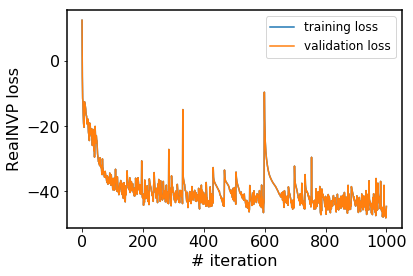

In [162]:
plt.figure()
plt.plot(np.asarray(nvp_tloss),label='training loss')
plt.plot(np.asarray(nvp_vloss),label='validation loss' )
plt.xlabel('# iteration')
plt.ylabel('RealNVP loss')
plt.legend()

### Save the trained model:

In [72]:
nvp_path = os.path.join(params['module_dir'],'run2_nepoch%d'%ii)
nvp_funcs.export(nvp_path,sess)

## Plots to test how well the model has performed

### 1) compare distributions in u-space. Data in u_space should match Gaussian prior

In [163]:
bwd.shape

TensorShape([None, 8])

In [164]:
bwd_train = sess.run(bwd,  feed_dict={data:z_sample})
bwd_valid = sess.run(bwd,  feed_dict={data:z_sample_valid})
Gaussian_sample = sess.run(prior_sample,  feed_dict={bs:len(z_sample)})

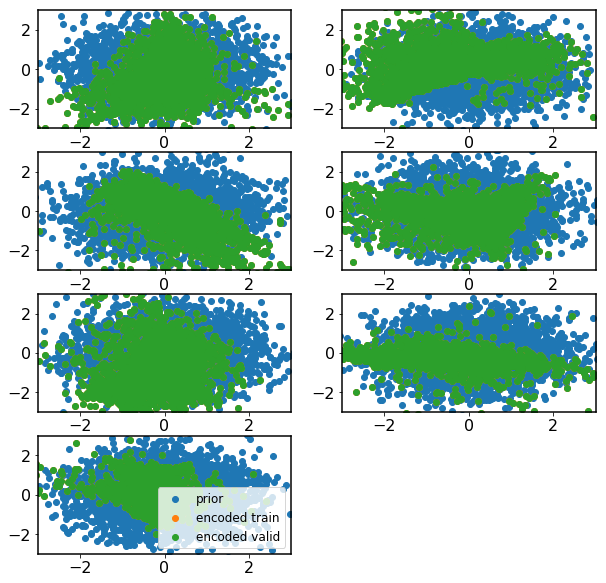

In [165]:
plt.figure(figsize=(10,10))
for nn in range(params['latent_size']-1):
    plt.subplot(4,2, nn+1)
    plt.scatter(Gaussian_sample[:,nn],Gaussian_sample[:,nn+1], label='prior')
    plt.scatter(bwd_train[:,nn],bwd_train[:,nn+1],label='encoded train')
    plt.scatter(bwd_valid[:,nn],bwd_valid[:,nn+1], label='encoded valid')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
plt.legend()
plt.show()

### 1) compare distributions in z-space. Data in z_space should match Gaussian prior samples forward modeled to z-space

In [166]:
fwd_sample = sess.run(fwd, feed_dict={latent_sample:Gaussian_sample})
input_data = sess.run(comp_data,  feed_dict={data:emb})

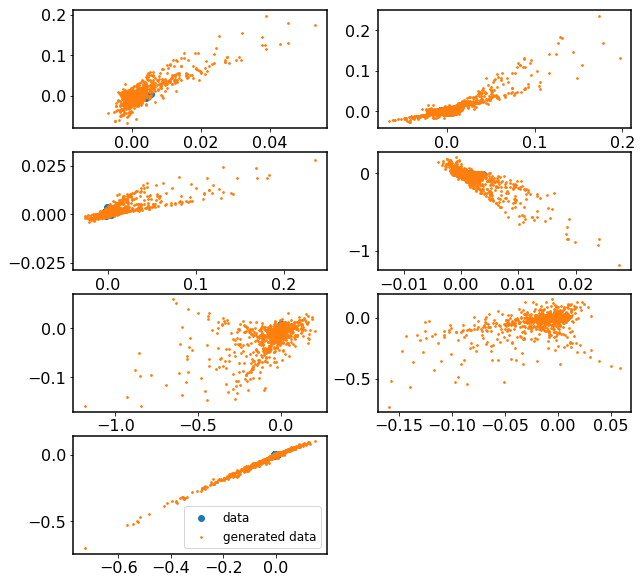

In [167]:
plt.figure(figsize=(10,10))
for nn in range(params['latent_size']-1):
    plt.subplot(4,2, nn+1)
    plt.scatter(input_data[:,nn],input_data[:,nn+1], label='data')
    plt.scatter(fwd_sample[:,nn],fwd_sample[:,nn+1],s=3, label='generated data')
plt.legend()

In [171]:
Gaussian_sample.shape

(3600, 8)

In [154]:
bwd_train.shape

(3600, 8)

In [155]:
bwd_valid.shape

(3600, 8)

In [156]:
fwd_sample.shape

(3600, 8)

In [85]:
generated_data = np.concatenate([bwd_train,bwd_valid],0)

In [86]:
generated_data.shape

(3600, 8)

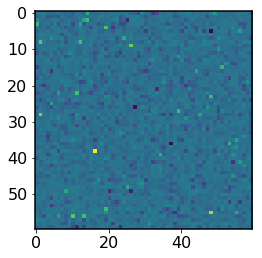

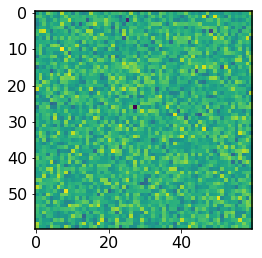

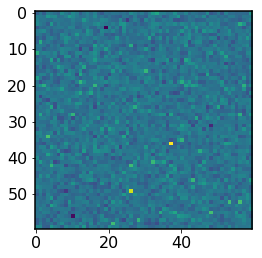

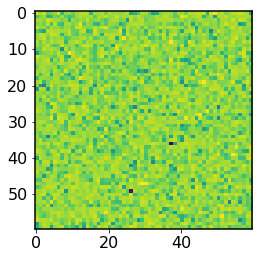

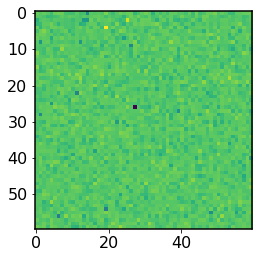

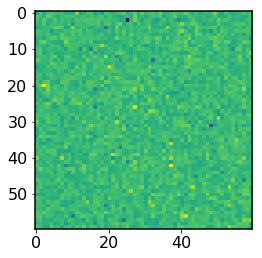

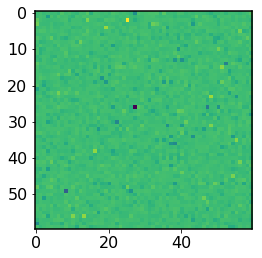

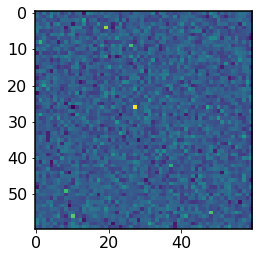

In [173]:
for i in range(8):
    plt.figure()
    plt.imshow(bwd_train[:,i].reshape(60,60))